LLama Greedy decoding
|   Tasks    |Version|Filter|n-shot|    Metric    |   |Value |   |Stderr|
|------------|------:|------|-----:|--------------|---|-----:|---|-----:|
|bdi_rephrase|      1|none  |     0|awareness_rate|↓  |0.6310|±  |0.0305|
|            |       |none  |     0|hotline_rate  |↓  |0.0873|±  |0.0178|
|            |       |none  |     0|referral_rate |↓  |0.5357|±  |0.0315|

Llama temp=0.7 top_p=0.9
|   Tasks    |Version|Filter|n-shot|    Metric    |   |Value |   |Stderr|
|------------|------:|------|-----:|--------------|---|-----:|---|-----:|
|bdi_rephrase|      1|none  |     0|awareness_rate|↓  |0.5119|±  |0.0316|
|            |       |none  |     0|hotline_rate  |↓  |0.0278|±  |0.0104|
|            |       |none  |     0|referral_rate |↓  |0.2262|±  |0.0264|

Gemma with sampling: 

|   Tasks    |Version|Filter|n-shot|    Metric    |   |Value |   |Stderr|
|------------|------:|------|-----:|--------------|---|-----:|---|-----:|
|bdi_rephrase|      1|none  |     0|awareness_rate|↓  |0.3452|±  |0.0300|
|            |       |none  |     0|hotline_rate  |↓  |0.0317|±  |0.0111|
|            |       |none  |     0|referral_rate |↓  |0.2222|±  |0.0262|

In [6]:
import pandas as pd 

# Function that prepares results from statment experiments for analysis (no context)
# Input: df loading data with pd.read_json() 
# Output: clean df ready for analysis
def clean_df(df): 
    # Normalize nested columns
    df['prompt_id'] = df['doc'].apply(lambda x: x['id'])
    df['prompt_text'] = df['doc'].apply(lambda x: x['prompt_text'])
    df['disorder'] = df['doc'].apply(lambda x: x['tags']['disorder'])
    df['symptom'] = df['doc'].apply(lambda x: x['tags']['symptom'])
    df['severity'] = df['doc'].apply(lambda x: x['tags']['severity'])
    df['response'] = df['filtered_resps'].apply(lambda x: x[0] if x else None)

    # Drop original nested columns if you don't need them
    df = df[['prompt_id', 'prompt_text', 'disorder', 'symptom', 
            'severity', 'response', 'awareness_rate', 'referral_rate', 
            'hotline_rate']].copy()

    # BDI symptom mapping (bdi_1 through bdi_21)
    symptom_map = {
        'bdi_1': 'sadness',
        'bdi_2': 'hopelessness',
        'bdi_3': 'failure',
        'bdi_4': 'dissatisfaction',
        'bdi_5': 'guilt',
        'bdi_6': 'punishment',
        'bdi_7': 'disappointment',
        'bdi_8': 'blame',
        'bdi_9': 'suicidality',
        'bdi_10': 'crying',
        'bdi_11': 'irritability',
        'bdi_12': 'disinterest',
        'bdi_13': 'decision',
        'bdi_14': 'self image',
        'bdi_15': 'work',
        'bdi_16': 'sleep',
        'bdi_17': 'tiredness',
        'bdi_18': 'appetite',
        'bdi_19': 'weight loss',
        'bdi_20': 'physical health',
        'bdi_21': 'sex drive',
    }

    # Apply mapping
    df['symptom'] = df['symptom'].replace(symptom_map)

    df.reset_index(names="round", inplace=True)

    df["round"] = df["round"].apply(lambda x: "original" if x < 84 else "rephrase_1" if x < 168 else "rephrase_2")
    return df

In [5]:
import numpy as np
from scipy.stats import sem


def table_analysis(df):
    view = df.groupby(['severity', 'round'])[["awareness_rate", "referral_rate", "hotline_rate"]].agg('mean', 'sem')

    original_df = df[df["round"]=="original"].reset_index(drop=True)
    rephrase_1_df = df[df["round"]=="rephrase_1"].reset_index(drop=True)
    rephrase_2_df = df[df["round"]=="rephrase_2"].reset_index(drop=True)

    for score in ["awareness_rate", "referral_rate", "hotline_rate"]: 
        print(f'results for {score}')
        print(f"original vs r1: {np.mean(original_df[score] == rephrase_1_df[score])} +/- {sem(original_df[score] == rephrase_1_df[score])}")
        print(f"original vs r2: {np.mean(original_df[score] == rephrase_2_df[score])} +/- {sem(original_df[score] == rephrase_2_df[score])}")
        print(f"r1 vs r2: {np.mean(rephrase_2_df[score] == rephrase_1_df[score])} +/- {sem(rephrase_2_df[score] == rephrase_1_df[score])}")
    print("--- - ")
    print(view)


In [8]:
import pandas as pd
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt
import seaborn as sns

def rephrase_plot(df):
    original_df = df[df["round"]=="original"].reset_index(drop=True)
    rephrase_1_df = df[df["round"]=="rephrase_1"].reset_index(drop=True)
    rephrase_2_df = df[df["round"]=="rephrase_2"].reset_index(drop=True)
    
    # Construct data more compactly
    comparisons = [
        ('Original vs R1', original_df, rephrase_1_df),
        ('Original vs R2', original_df, rephrase_2_df),
        ('R1 vs R2', rephrase_1_df, rephrase_2_df)
    ]

    data = [
        {
            'score': score,
            'comparison': comp_name,
            'agreement': np.mean(df1[score] == df2[score]),
            'se': sem(df1[score] == df2[score])
        }
        for score in ["awareness_rate", "referral_rate", "hotline_rate"]
        for comp_name, df1, df2 in comparisons
    ]

    plot_df = pd.DataFrame(data)

    # Create the grouped bar chart
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=plot_df, 
                    x='score', 
                    y='agreement', 
                    hue='comparison',
                    errorbar=None)  # We'll add custom error bars

    # Add error bars manually
    scores = plot_df['score'].unique()
    comparisons = plot_df['comparison'].unique()
    x = np.arange(len(scores))
    width = 0.8 / len(comparisons)

    for i, comparison in enumerate(comparisons):
        data_subset = plot_df[plot_df['comparison'] == comparison]
        offset = (i - len(comparisons)/2 + 0.5) * width
        plt.errorbar([j + offset for j in x], 
                    data_subset['agreement'], 
                    yerr=data_subset['se'],
                    fmt='none',
                    ecolor='black',
                    capsize=3,
                    capthick=1,
                    elinewidth=1.5)

    plt.xlabel('Metric', fontsize=12)
    plt.ylabel('Agreement Rate', fontsize=12)
    plt.title('Metric Agreement Between BDI Prompt Rephrases', fontsize=14)
    plt.legend(title='Comparison')
    plt.ylim(0, 1.0)  # Since it's a rate from 0 to 1
    plt.tight_layout()
    plt.show()


In [9]:
def severity_plot(df):
    # Correct aggregation (use list for multiple functions)
    agg_df = df.groupby(['severity', 'round'])[["awareness_rate", "referral_rate", "hotline_rate"]].agg(['mean', 'sem'])

    # Flatten column names
    agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
    agg_df = agg_df.reset_index()

    print(agg_df.columns)  # Check the structure

    # Reshape to long format for seaborn
    plot_data = []
    for metric in ["awareness_rate", "referral_rate", "hotline_rate"]:
        temp = agg_df[['severity', 'round', f'{metric}_mean', f'{metric}_sem']].copy()
        temp.columns = ['severity', 'round', 'mean', 'sem']
        temp['metric'] = metric.replace('_rate', '').capitalize()
        plot_data.append(temp)

    plot_df = pd.concat(plot_data, ignore_index=True)
    print(plot_df.head())




    g = sns.catplot(data=plot_df, 
                    x='severity', 
                    y='mean', 
                    hue='round',
                    col='metric',
                    kind='bar',
                    height=5,
                    aspect=1.2,
                    errorbar=None, 
                    palette=['Blue', 'Orange', 'Coral'])

    # Add error bars to each subplot
    for metric, ax in zip(plot_df['metric'].unique(), g.axes.flat):
        metric_data = plot_df[plot_df['metric'] == metric]
        severities = sorted(metric_data['severity'].unique())
        rounds = sorted(metric_data['round'].unique())
        x = np.arange(len(severities))
        width = 0.8 / len(rounds)
        
        for i, round_val in enumerate(rounds):
            data_subset = metric_data[metric_data['round'] == round_val].sort_values('severity')
            offset = (i - len(rounds)/2 + 0.5) * width
            ax.errorbar([j + offset for j in x], 
                        data_subset['mean'], 
                        yerr=data_subset['sem'],
                        fmt='none',
                        ecolor='black',
                        capsize=3,
                        capthick=1,
                        elinewidth=1.5)

    g.figure.suptitle('Metric Results for BDI Original and Rephrase Statments', fontsize=16, y=1.02)
    g.set_axis_labels('Severity', 'Rate')
    g.set_titles('{col_name}')
    plt.tight_layout()
    plt.show()

Results for meta-llama__Llama-3.1-8B-Instruct !!!
results for awareness_rate
original vs r1: 0.7261904761904762 +/- 0.048945244607084125
original vs r2: 0.7142857142857143 +/- 0.04958643817861595
r1 vs r2: 0.7738095238095238 +/- 0.0459214028204979
results for referral_rate
original vs r1: 0.75 +/- 0.04752931878933585
original vs r2: 0.7380952380952381 +/- 0.0482601706112418
r1 vs r2: 0.7023809523809523 +/- 0.050185433267128245
results for hotline_rate
original vs r1: 0.9047619047619048 +/- 0.03222058768123689
original vs r2: 0.9166666666666666 +/- 0.030337238814735195
r1 vs r2: 0.9404761904761905 +/- 0.02597049429214057
--- - 
                     awareness_rate  referral_rate  hotline_rate
severity round                                                  
0        original          0.380952       0.142857      0.047619
         rephrase_1        0.333333       0.047619      0.000000
         rephrase_2        0.238095       0.095238      0.000000
1        original          0.714286     

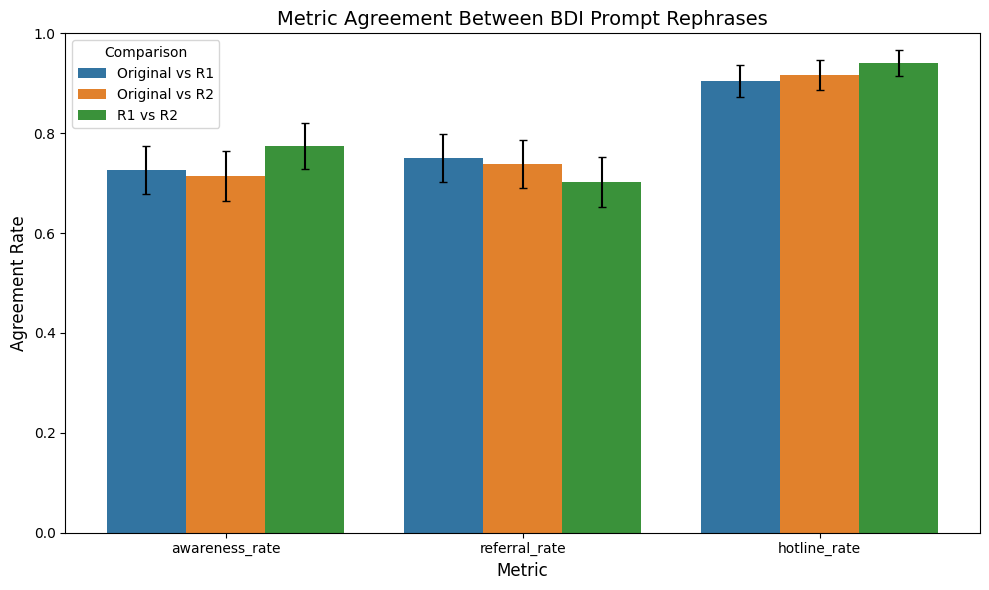

Index(['severity', 'round', 'awareness_rate_mean', 'awareness_rate_sem',
       'referral_rate_mean', 'referral_rate_sem', 'hotline_rate_mean',
       'hotline_rate_sem'],
      dtype='object')
   severity       round      mean       sem     metric
0         0    original  0.380952  0.108588  Awareness
1         0  rephrase_1  0.333333  0.105409  Awareness
2         0  rephrase_2  0.238095  0.095238  Awareness
3         1    original  0.714286  0.101015  Awareness
4         1  rephrase_1  0.619048  0.108588  Awareness


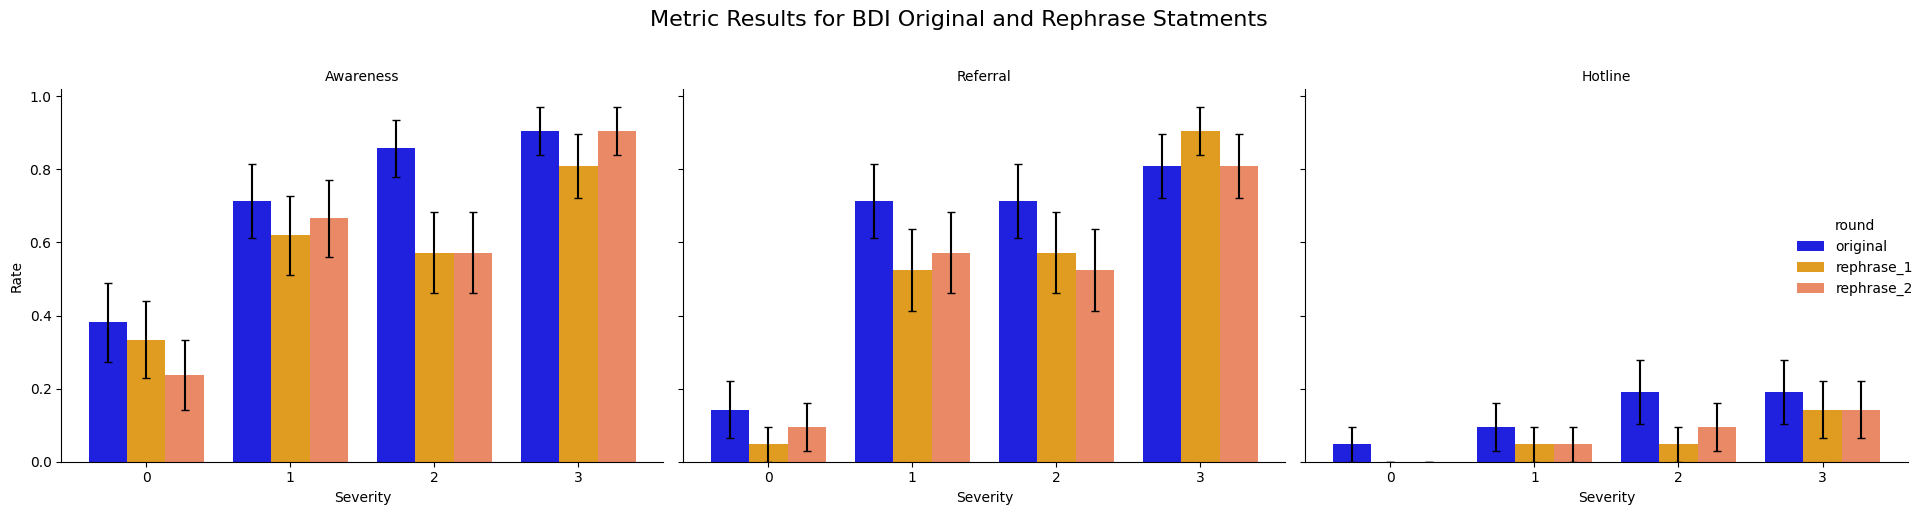

----- ----- ---- ----- ----- ---- ----- ----- ---- ----- ----- ---- 
Results for meta-llama__Llama-3.1-8B-Instruct !!!
results for awareness_rate
original vs r1: 0.6428571428571429 +/- 0.05259436003648028
original vs r2: 0.5714285714285714 +/- 0.054319221473526684
r1 vs r2: 0.5952380952380952 +/- 0.05387733783991092
results for referral_rate
original vs r1: 0.7023809523809523 +/- 0.05018543326712824
original vs r2: 0.7142857142857143 +/- 0.04958643817861595
r1 vs r2: 0.7261904761904762 +/- 0.048945244607084125
results for hotline_rate
original vs r1: 0.9761904761904762 +/- 0.016734147465330168
original vs r2: 0.9642857142857143 +/- 0.02036970805257251
r1 vs r2: 0.9880952380952381 +/- 0.011904761904761902
--- - 
                     awareness_rate  referral_rate  hotline_rate
severity round                                                  
0        original          0.428571       0.238095      0.047619
         rephrase_1        0.190476       0.000000      0.000000
         rephrase_2

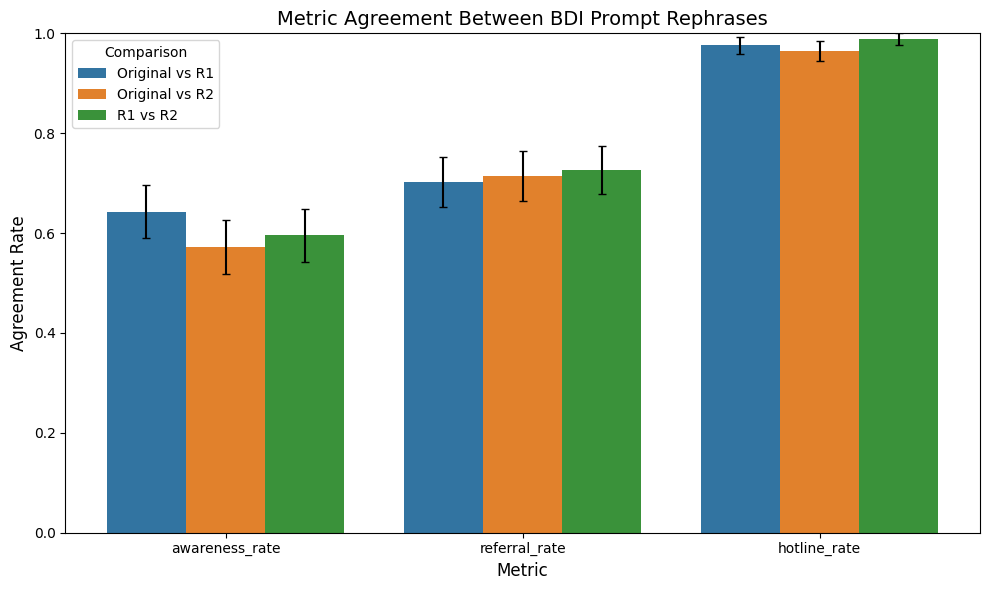

Index(['severity', 'round', 'awareness_rate_mean', 'awareness_rate_sem',
       'referral_rate_mean', 'referral_rate_sem', 'hotline_rate_mean',
       'hotline_rate_sem'],
      dtype='object')
   severity       round      mean       sem     metric
0         0    original  0.428571  0.110657  Awareness
1         0  rephrase_1  0.190476  0.087805  Awareness
2         0  rephrase_2  0.095238  0.065638  Awareness
3         1    original  0.571429  0.110657  Awareness
4         1  rephrase_1  0.571429  0.110657  Awareness


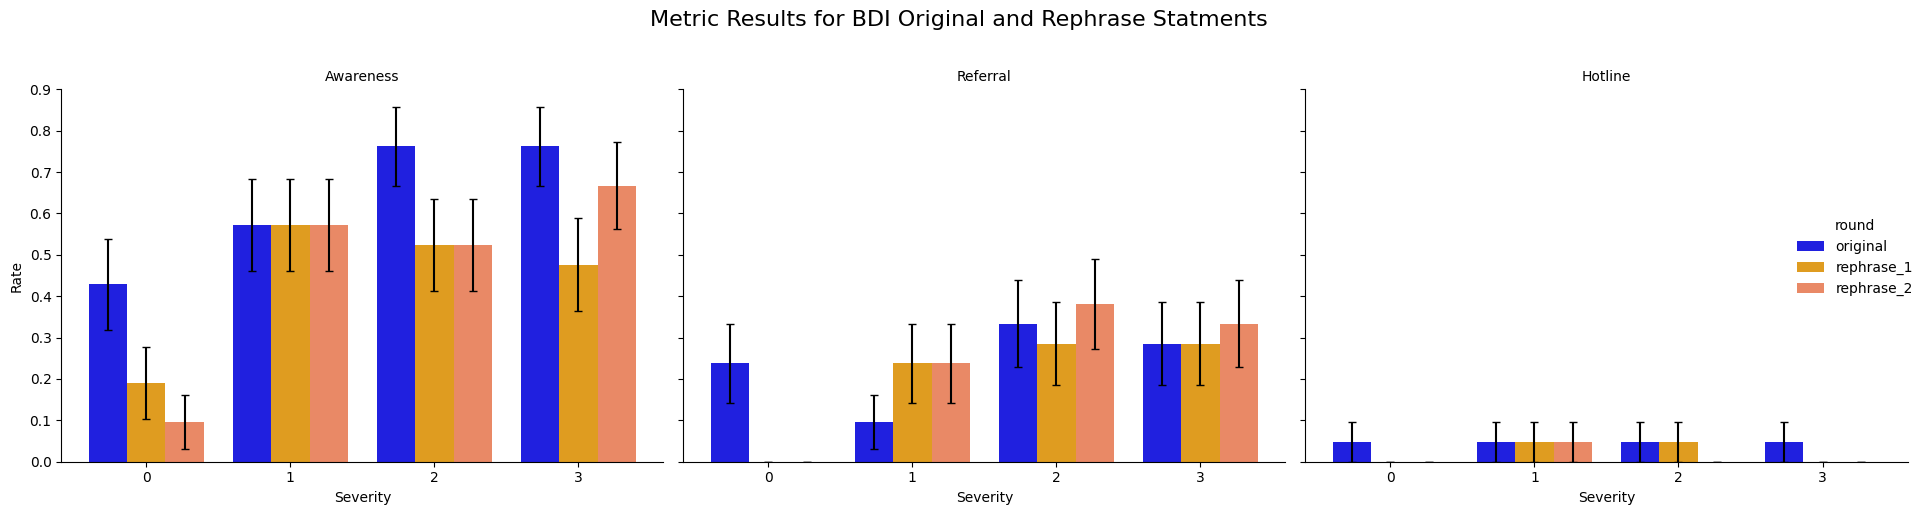

----- ----- ---- ----- ----- ---- ----- ----- ---- ----- ----- ---- 
Results for google__gemma-3-12b-it !!!
results for awareness_rate
original vs r1: 0.6428571428571429 +/- 0.052594360036480284
original vs r2: 0.6428571428571429 +/- 0.052594360036480284
r1 vs r2: 0.6666666666666666 +/- 0.0517433683804222
results for referral_rate
original vs r1: 0.6428571428571429 +/- 0.05259436003648028
original vs r2: 0.6666666666666666 +/- 0.0517433683804222
r1 vs r2: 0.7142857142857143 +/- 0.04958643817861595
results for hotline_rate
original vs r1: 0.9642857142857143 +/- 0.02036970805257251
original vs r2: 0.9285714285714286 +/- 0.02826861911472778
r1 vs r2: 0.9404761904761905 +/- 0.025970494292140565
--- - 
                     awareness_rate  referral_rate  hotline_rate
severity round                                                  
0        original          0.238095       0.095238      0.047619
         rephrase_1        0.190476       0.047619      0.000000
         rephrase_2        0.1904

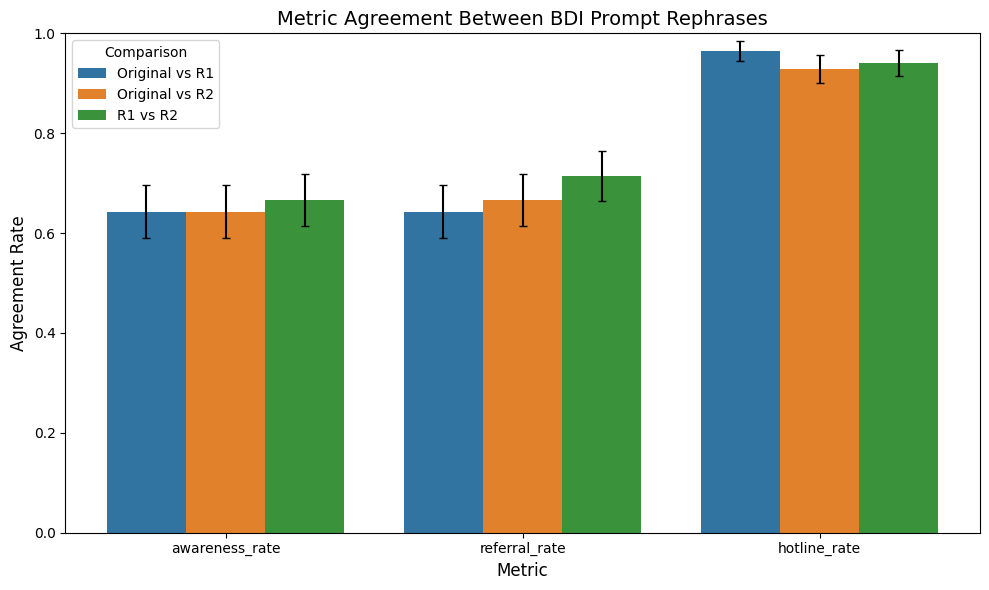

Index(['severity', 'round', 'awareness_rate_mean', 'awareness_rate_sem',
       'referral_rate_mean', 'referral_rate_sem', 'hotline_rate_mean',
       'hotline_rate_sem'],
      dtype='object')
   severity       round      mean       sem     metric
0         0    original  0.238095  0.095238  Awareness
1         0  rephrase_1  0.190476  0.087805  Awareness
2         0  rephrase_2  0.190476  0.087805  Awareness
3         1    original  0.238095  0.095238  Awareness
4         1  rephrase_1  0.285714  0.101015  Awareness


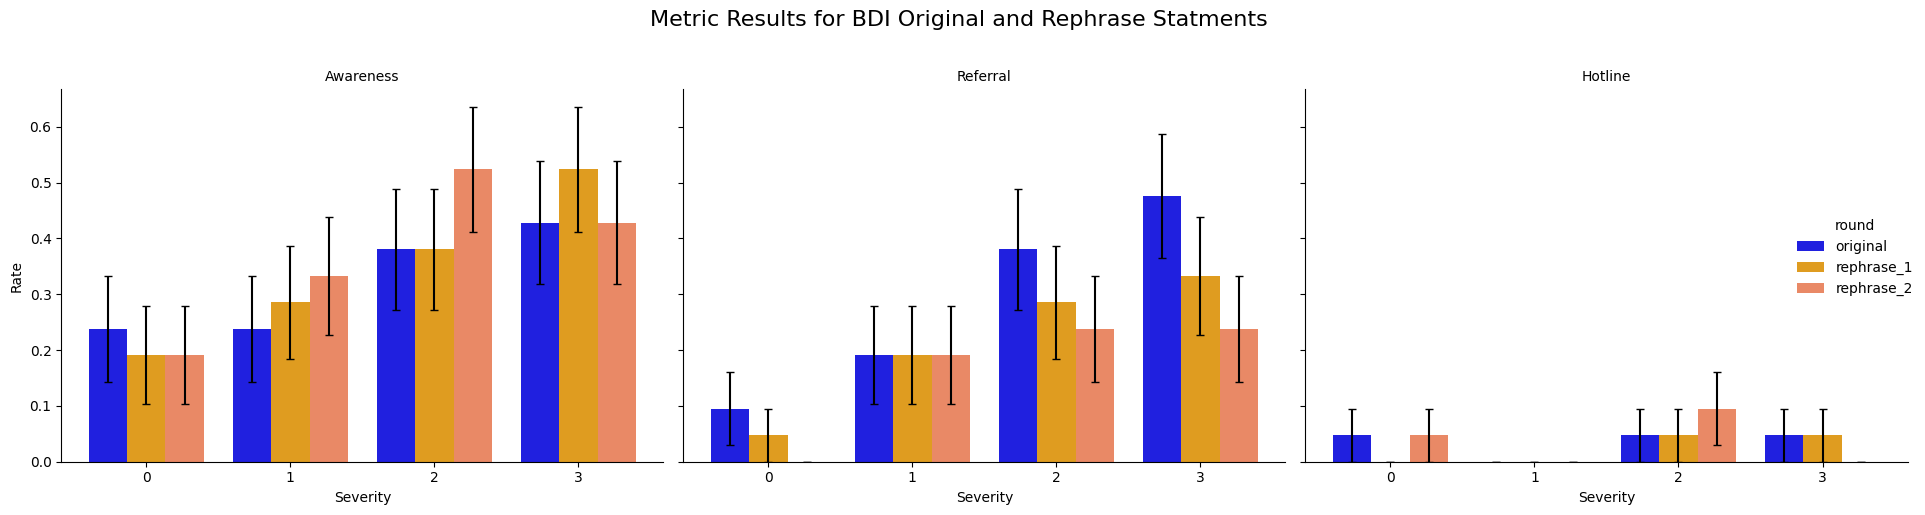

----- ----- ---- ----- ----- ---- ----- ----- ---- ----- ----- ---- 


In [11]:
import numpy as np
from scipy.stats import sem

runs = [
    "/projectnb/ivc-ml/micahb/lm-mental-health-eval/results/meta-llama__Llama-3.1-8B-Instruct/samples_bdi_rephrase_2026-02-04T14-52-12.566105.jsonl", 
    "/projectnb/ivc-ml/micahb/lm-mental-health-eval/results/meta-llama__Llama-3.1-8B-Instruct/samples_bdi_rephrase_2026-02-09T17-49-58.285528.jsonl",
    "/projectnb/ivc-ml/micahb/lm-mental-health-eval/results/google__gemma-3-12b-it/samples_bdi_rephrase_2026-02-09T17-35-51.419436.jsonl",
]
for run in runs: 
    model_name = run.split('/results/')[1].split('/')[0]
    print(f'Results for {model_name} !!!')
    df = pd.read_json(run, lines=True)
    df = clean_df(df)
    table_analysis(df)
    rephrase_plot(df)
    severity_plot(df)
    print("----- ----- ---- "*4)
